## Precision top K

In [8]:
# Initialization: Load shared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   204k      0 --:--:-- --:--:-- --:--:--  205k


In [9]:
# Load data from the 2018-07-25 to the 2018-08-14

DIR_INPUT='./simulated-data-transformed/data/'

BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=7

(train_df,test_df)=get_train_test_set(transactions_df,start_date_training,
                                      delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df,
                                                                 input_features, output_feature)

Load  files
CPU times: user 91.7 ms, sys: 137 ms, total: 229 ms
Wall time: 234 ms
201295 transactions loaded, containing 1792 fraudulent transactions


In [10]:
assert len(model_and_predictions_dictionary['predictions_test'])==len(test_df)

In [11]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
predictions_df[['TRANSACTION_ID','TX_DATETIME','CUSTOMER_ID','TERMINAL_ID','TX_AMOUNT','TX_TIME_DAYS','TX_FRAUD','predictions']].head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_DAYS,TX_FRAUD,predictions
134215,1236698,2018-08-08 00:01:14,2765,2747,-0.266899,129,0,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,1.295440,129,0,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,-0.650902,129,0,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,0.290249,129,0,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,0.039070,129,0,0.003536


In [12]:
def precision_top_k_day(df_day, top_k=100):

    # Order transactions by decreasing probabilities of frauds
    df_day = df_day.sort_values(by="predictions", ascending=False).reset_index(drop=False)

    # Get the top k most suspicious transactions
    df_day_top_k=df_day.head(top_k)
    list_detected_fraudulent_transactions=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].TRANSACTION_ID)

    # Compute precision top k
    precision_top_k = len(list_detected_fraudulent_transactions) / top_k

    return list_detected_fraudulent_transactions, precision_top_k


day=129

df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
df_day = df_day[['TRANSACTION_ID','CUSTOMER_ID', 'TX_FRAUD', 'predictions']]

_, precision_top_k= precision_top_k_day(df_day=df_day, top_k=100)
precision_top_k

0.26

In [13]:
def precision_top_k(predictions_df, top_k=100):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()

    precision_top_k_per_day_list = []
    nb_fraudulent_transactions_per_day = []

    # For each day, compute precision top k
    for day in list_days:

        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['TRANSACTION_ID', 'CUSTOMER_ID', 'TX_FRAUD', 'predictions']]

        nb_fraudulent_transactions_per_day.append(len(df_day[df_day.TX_FRAUD==1]))

        _, _precision_top_k = precision_top_k_day(df_day, top_k=top_k)

        precision_top_k_per_day_list.append(_precision_top_k)

    # Compute the mean
    mean_precision_top_k = np.round(np.array(precision_top_k_per_day_list).mean(),3)

    # Returns number of fraudulent transactions per day,
    # precision top k per day, and resulting mean
    return nb_fraudulent_transactions_per_day,precision_top_k_per_day_list,mean_precision_top_k

In [14]:
nb_fraudulent_transactions_per_day_remaining,\
precision_top_k_per_day_list,\
mean_precision_top_k = precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining fraudulent transactions: "+str(nb_fraudulent_transactions_per_day_remaining))
print("Precision top-k: "+str(precision_top_k_per_day_list))
print("Average Precision top-k: "+str(mean_precision_top_k))

Number of remaining fraudulent transactions: [55, 60, 56, 56, 59, 58, 41]
Precision top-k: [0.26, 0.35, 0.26, 0.33, 0.3, 0.35, 0.19]
Average Precision top-k: 0.291


In [15]:
# Compute the number of transactions per day,
#fraudulent transactions per day and fraudulent cards per day
tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

# Add the remaining number of fraudulent transactions for the last 7 days (test period)
tx_stats.loc[14:20,'nb_fraudulent_transactions_per_day_remaining']=list(nb_fraudulent_transactions_per_day_remaining)
# Add precision top k for the last 7 days (test period)
tx_stats.loc[14:20,'precision_top_k_per_day']=precision_top_k_per_day_list

In [17]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

cmap = plt.get_cmap('jet')
colors={'precision_top_k_per_day':cmap(0),
        'nb_fraudulent_transactions_per_day':cmap(200),
        'nb_fraudulent_transactions_per_day_remaining':cmap(250),
       }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Number of fraudulent transactions per day \n and number of detected fraudulent transactions',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test,
                      ylim=150
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day - Original')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day_remaining'], 'b', color=colors['nb_fraudulent_transactions_per_day_remaining'], label = '# fraudulent txs per day - Remaining')
ax.plot(tx_stats['tx_date'], tx_stats['precision_top_k_per_day']*100, 'b', color=colors['precision_top_k_per_day'], label = '# detected fraudulent txs per day')
ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

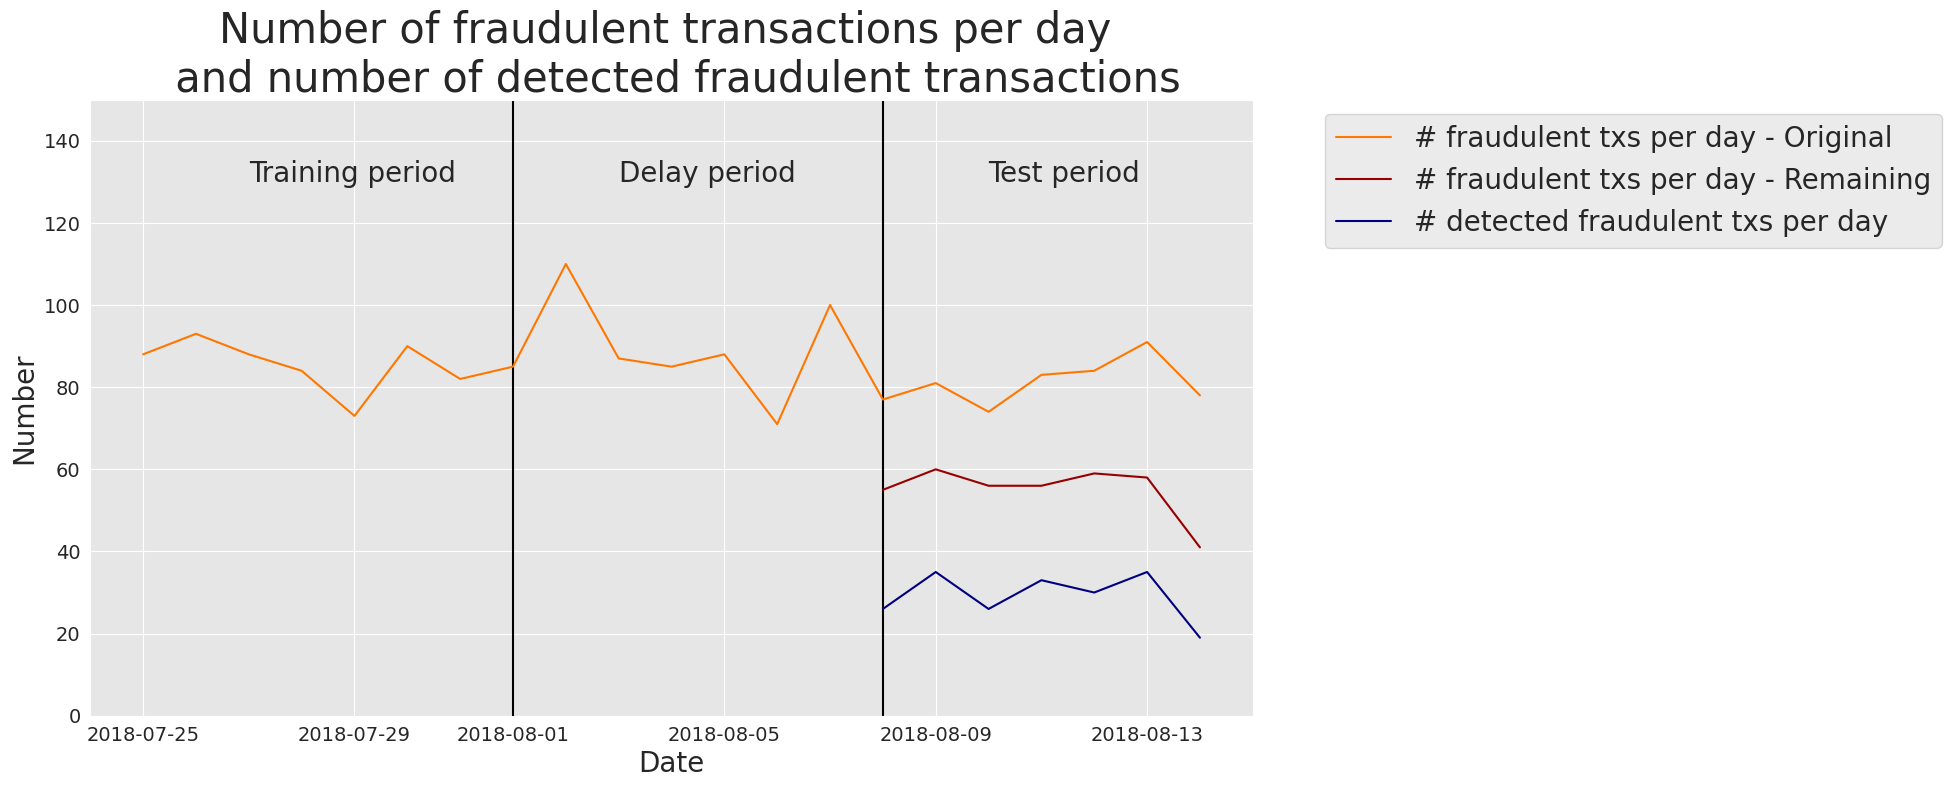

In [18]:
fraud_and_transactions_stats_fig

## Card Precision top K

In [19]:
def card_precision_top_k_day(df_day, top_k):

    # This takes the max of the predictions AND the max of label TX_FRAUD for each CUSTOMER_ID,
    # and sorts by decreasing order of fraudulent prediction
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)

    # Get the top k most suspicious cards
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)

    # Compute precision top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k

    return list_detected_compromised_cards, card_precision_top_k

day=129

df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

_,card_precision_top_k= card_precision_top_k_day(df_day=df_day, top_k=100)
card_precision_top_k

0.24

In [20]:
def card_precision_top_k(predictions_df, top_k):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()

    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []

    # For each day, compute precision top k
    for day in list_days:

        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))

        _, card_precision_top_k = card_precision_top_k_day(df_day,top_k)

        card_precision_top_k_per_day_list.append(card_precision_top_k)

    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()

    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

In [21]:
nb_compromised_cards_per_day_remaining\
,card_precision_top_k_per_day_list\
,mean_card_precision_top_k=card_precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining compromised cards: "+str(nb_compromised_cards_per_day_remaining))
print("Precision top-k: "+str(card_precision_top_k_per_day_list))
print("Average Precision top-k: "+str(mean_card_precision_top_k))

Number of remaining compromised cards: [50, 54, 51, 54, 55, 54, 38]
Precision top-k: [0.24, 0.35, 0.26, 0.32, 0.3, 0.34, 0.19]
Average Precision top-k: 0.2857142857142857


In [22]:
# Compute the number of transactions per day,
# fraudulent transactions per day and fraudulent cards per day
tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

# Add the remaining number of compromised cards for the last 7 days (test period)
tx_stats.loc[14:20,'nb_compromised_cards_per_day_remaining']=list(nb_compromised_cards_per_day_remaining)

# Add the card precision top k for the last 7 days (test period)
tx_stats.loc[14:20,'card_precision_top_k_per_day']=card_precision_top_k_per_day_list

In [23]:
%%capture

# Plot the number of transactions per day, fraudulent transactions per day and fraudulent cards per day

cmap = plt.get_cmap('jet')
colors={'card_precision_top_k_per_day':cmap(0),
        'nb_compromised_cards_per_day':cmap(200),
        'nb_compromised_cards_per_day_remaining':cmap(250),
       }

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Number of fraudulent transactions per day \n and number of detected fraudulent transactions',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test,
                      ylim=150
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# fraudulent txs per day - Original')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day_remaining'], 'b', color=colors['nb_compromised_cards_per_day_remaining'], label = '# compromised cards per day - Remaining')
ax.plot(tx_stats['tx_date'], tx_stats['card_precision_top_k_per_day']*100, 'b', color=colors['card_precision_top_k_per_day'], label = '# detected compromised cards per day')
ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1), fontsize=20)


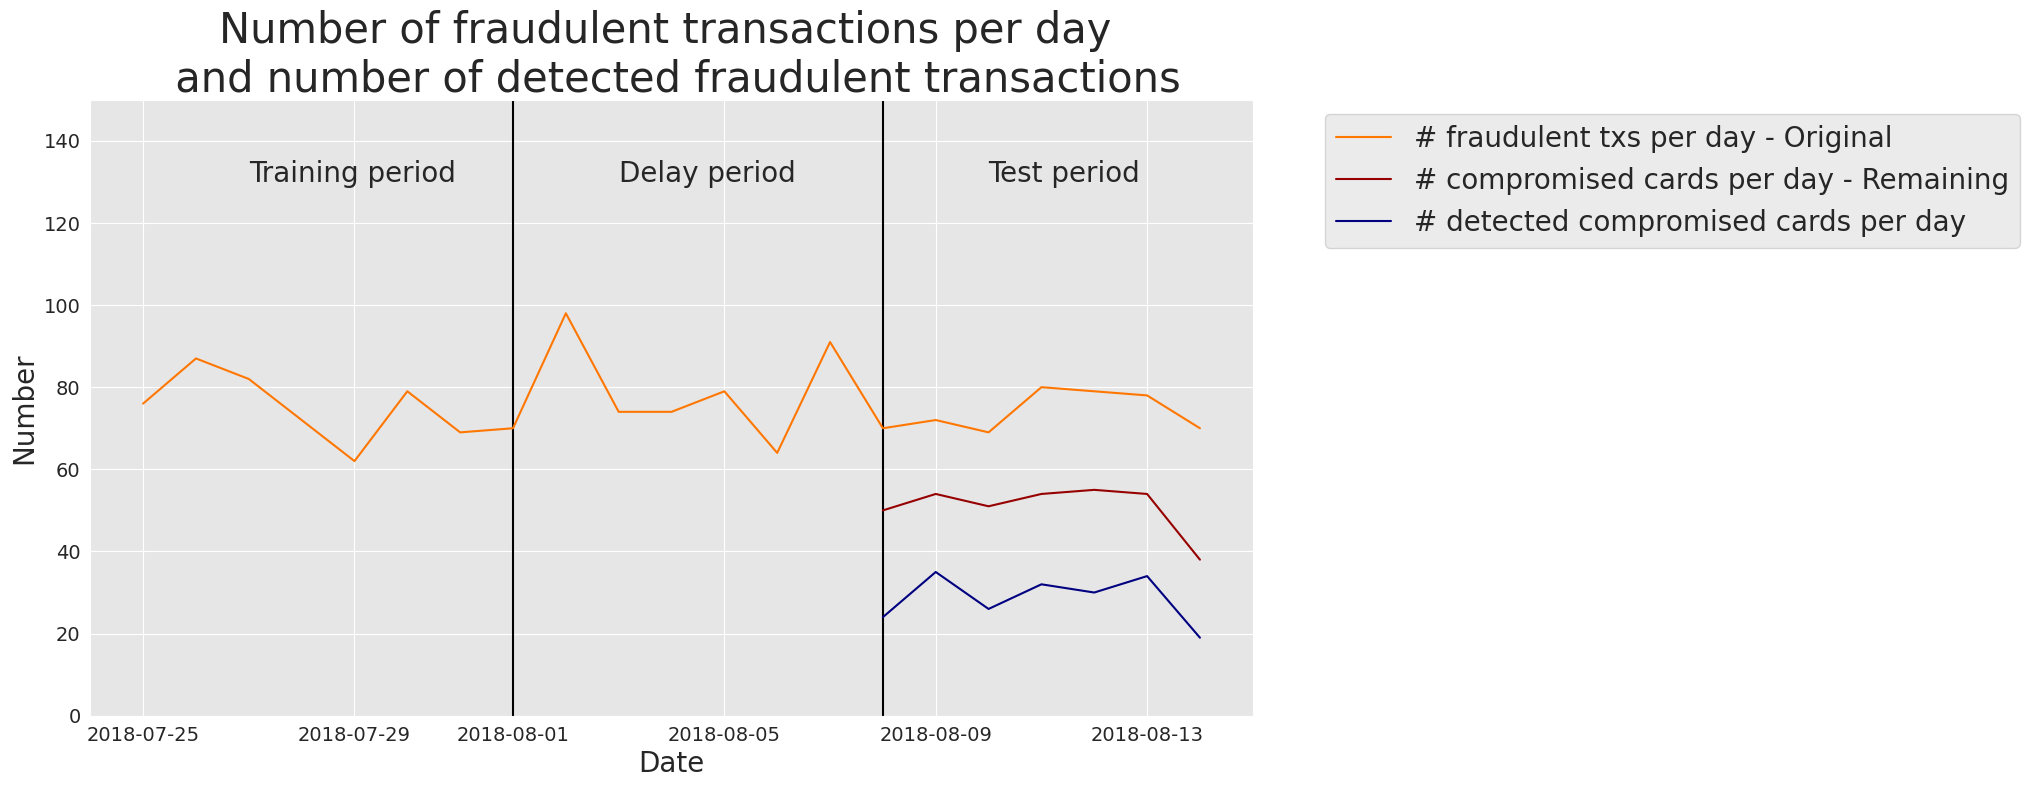

In [24]:
fraud_and_transactions_stats_fig

In [26]:
def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Sort days by increasing order
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()

    # At first, the list of detected compromised cards is empty
    list_detected_compromised_cards = []

    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []

    # For each day, compute precision top k
    for day in list_days:

        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]

        # Let us remove detected compromised cards from the set of daily transactions
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]

        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))

        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)

        card_precision_top_k_per_day_list.append(card_precision_top_k)

        # Let us update the list of detected compromised cards
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)

    # Compute the mean
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()

    # Returns precision top k per day as a list, and resulting mean
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

In [27]:
nb_compromised_cards_per_day_remaining\
,card_precision_top_k_per_day_list\
,mean_card_precision_top_k=card_precision_top_k(predictions_df=predictions_df, top_k=100)

print("Number of remaining compromised cards: "+str(nb_compromised_cards_per_day_remaining))
print("Precision top-k: "+str(card_precision_top_k_per_day_list))
print("Average Precision top-k: "+str(mean_card_precision_top_k))

Number of remaining compromised cards: [50, 50, 49, 47, 46, 44, 31]
Precision top-k: [0.24, 0.32, 0.27, 0.25, 0.23, 0.26, 0.12]
Average Precision top-k: 0.2414285714285714
